In [14]:
# importing the required libraries
import numpy as np
from matplotlib import pyplot as plt 
import os
import json
import requests
import datetime
from IPython.display import HTML, display

In [6]:
# function to extract the required PIDs from the string LABELS
def extract_PID_data(data, PROTOCOL,LABEL):
    
    if (PROTOCOL == 'SAE'):

        if LABEL == 'ENGINE LOAD': # Engine Load
            PID_TAG = 'spn_92_avg'
        elif LABEL == 'ENGINE RPM': # Engine Speed (RPM)
            PID_TAG = 'spn_190_avg'
        elif LABEL == 'DPFDP': # DPF Diffrential Pressure (across DPF)
            PID_TAG = 'spn_3251_avg'
        elif LABEL == 'SPEED': # Wheep based Vehicle Speed
            PID_TAG = 'spn_84_avg'
        elif LABEL == 'DPFINT':# DPF in Temperature Before DPF (DOC out)
            PID_TAG = 'spn_3250_avg' 
        elif LABEL == 'SOOTLOAD_3719': #  Soot load  
            PID_TAG = 'spn_3719_avg' 
        elif LABEL == 'SOOTLOAD_5466': # Soot load (Regen threshold)    
            PID_TAG = 'spn_5466_avg'      
        elif LABEL == 'ACTIVEREGEN':  # Regen status
            PID_TAG = 'spn_3700_avg' 
                  

    Time_vec = []
    Val_vec = []
    
    for data_cnt in range(0,len(data)):
        if "pids" in data[data_cnt]:
            if len(data[data_cnt]['pids'])>0:
                for sub_pid_cnt in range(0,len(data[data_cnt]['pids'])):  #this loop
                    State = data[data_cnt]['pids'][sub_pid_cnt]
                    if PID_TAG in State:
                        #print("--------------------------------------------IN----------------------------------")
                        Time_vec.append(np.array(State[PID_TAG]['timestamp'], dtype=np.int64))
                        Val_vec.append(np.array(State[PID_TAG]['value'], dtype=float))
      
    return Time_vec,Val_vec

In [7]:
# this function checks whether all the values in an array lies in the range of [min_val, max_val]
def check_range(arr, min_val, max_val):
    return all(min_val <= x <= max_val for x in arr)

In [95]:
# function to perform the validation of data
def DBQ_VALIDATION(OBD_data):
    
    validation_status = 'PASSED'

    # validation for differential pressure
    LABEL = 'DPFDP'
    min_DP_val = 0    
    max_DP_val = 70
    DPFDP_Time, DPFDP_Value = extract_PID_data(OBD_data,'SAE',LABEL)

    # if no values present for the given PID
    if len(DPFDP_Value) == 0:
        validation_status = 'FAILED'

    # if values prsent for the PID
    elif (len(DPFDP_Value) != 0):
        # checking if the values prsent lie beyond the particular range and whether the variance is not constant 
        if (not check_range(DPFDP_Value, min_DP_val, max_DP_val))  or\
              ((np.std(DPFDP_Value) < 0.1*np.max(DPFDP_Value))) or (np.std(DPFDP_Value))==0:
                validation_status = 'FAILED'
            
    TS = []
    for cnt in range(0,len(DPFDP_Time)):
        TEMP = datetime.datetime.fromtimestamp((DPFDP_Time[cnt] + 19800*1000) / 1000.0, tz=datetime.timezone.utc)
        TS.append(TEMP)
        
    plt.subplot(8, 1, 1)
    plt.plot(TS,DPFDP_Value,'.b')
    plt.title(LABEL)
       
    # validation for the DPFIN temperature
    LABEL = 'DPFINT'
    min_DPFINT_val = 0    
    max_DPFINT_val = 700
    DPFINT_Time, DPFINT_Value = extract_PID_data(OBD_data,'SAE',LABEL)
    
    # if no values present for the given PID
    if (len(DPFINT_Value) == 0):
        validation_status = 'FAILED'

    # checking if the values prsent lie beyond the particular range and whether the variance is not constant 
    elif (len(DPFINT_Value) != 0):
        # checking if the values present lie beyond the particular range and whether the variance is not constant
        if (not check_range(DPFINT_Value, min_DPFINT_val, max_DPFINT_val)) or \
            (np.std(DPFINT_Value) < 0.1*np.max(DPFINT_Value)) or np.std(DPFINT_Value)==0:
                validation_status ='FAILED'
    TS = []
    for cnt in range(0,len(DPFINT_Time)):
        TEMP = datetime.datetime.fromtimestamp((DPFINT_Time[cnt] + 19800*1000) / 1000.0, tz=datetime.timezone.utc)
        TS.append(TEMP)
        
    plt.subplot(8, 1, 2)
    plt.plot(TS,DPFINT_Value,'.b')
    plt.title(LABEL)

    # validation for the Engine RPM
    LABEL = 'ENGINE RPM'
    min_RPM_val = 0    
    max_RPM_val = 3500
    RPM_Time, RPM_Value = extract_PID_data(OBD_data,'SAE',LABEL)
    
    if (len(RPM_Value) == 0):
        validation_status = 'FAILED'
    
    # checking if the values prsent lie beyond the particular range and whether the variance is not constant 
    elif (len(RPM_Value) != 0):
        if (not check_range(RPM_Value, min_RPM_val, max_RPM_val)) or \
            (np.std(RPM_Value) < 0.1*np.max(RPM_Value)) or np.std(RPM_Value)==0:
                validation_status = 'FAILED'
    TS = []
    for cnt in range(0,len(RPM_Time)):
        TEMP = datetime.datetime.fromtimestamp((RPM_Time[cnt] + 19800*1000) / 1000.0, tz=datetime.timezone.utc)
        TS.append(TEMP)
        
    plt.subplot(8, 1, 3)
    plt.plot(TS,RPM_Value,'.b')
    plt.title(LABEL)

    # validation for LOAD
    LABEL = 'ENGINE LOAD'
    min_LOAD_val = 0    
    max_LOAD_val = 100
    LOAD_Time, LOAD_Value = extract_PID_data(OBD_data,'SAE',LABEL)
    
    if (len(LOAD_Value) == 0):
        validation_status = 'FAILED'

    elif (len(LOAD_Value) != 0):
        if (not check_range(LOAD_Value, min_LOAD_val, max_LOAD_val)) or \
            (np.std(LOAD_Value) < 0.1*np.max(LOAD_Value)) or np.std(LOAD_Value)==0:
                validation_status = 'FAILED'
    TS = []
    for cnt in range(0,len(LOAD_Time)):
        TEMP = datetime.datetime.fromtimestamp((LOAD_Time[cnt] + 19800*1000) / 1000.0, tz=datetime.timezone.utc)
        TS.append(TEMP)
        
    plt.subplot(8, 1, 4)
    plt.plot(TS,LOAD_Value,'.b')
    plt.title(LABEL)
    
    # validation for the veichle speed
    LABEL = 'SPEED'
    min_SPEED_val = 0    
    max_SPEED_val = 200
    SPEED_Time, SPEED_Value = extract_PID_data(OBD_data,'SAE',LABEL)
    
    if (len(SPEED_Value) == 0):
         validation_status = 'FAILED'

    elif (len(SPEED_Value) != 0):
        if (not check_range(SPEED_Value, min_SPEED_val, max_SPEED_val)) or \
            (np.std(SPEED_Value) < 0.1*np.max(SPEED_Value)) or np.std(SPEED_Value)==0:
                validation_status = 'FAILED'
    TS = []
    for cnt in range(0,len(SPEED_Time)):
        TEMP = datetime.datetime.fromtimestamp((SPEED_Time[cnt] + 19800*1000) / 1000.0, tz=datetime.timezone.utc)
        TS.append(TEMP)
        
    plt.subplot(8, 1, 5)
    plt.plot(TS,SPEED_Value,'.b')
    plt.title(LABEL)
    
     # validation for Soot Load 3719
    LABEL = 'SOOTLOAD_3719'
    SL_3719_Time, SL_3719_Value = extract_PID_data(OBD_data,'SAE',LABEL)
    min_SL_val = 0    
    max_SL_val = 250
    if (len(SL_3719_Value) == 0):
        print('SOOTLOAD_3719 NOT AVAILABLE')
    else:
        if(not check_range(SL_3719_Value, min_SL_val, max_SL_val)):
            print('SOOTLOAD_3719 AVAILABLE BUT NOT ACCEPTED RANGE')
        elif(np.std(SL_3719_Value) < 0.1*np.max(SL_3719_Value)):
                print('SOOTLOAD_3719 AVAILABLE BUT CONSTANT VALUE')
    TS = []
    for cnt in range(0,len(SL_3719_Time)):
        TEMP = datetime.datetime.fromtimestamp((SL_3719_Time[cnt] + 19800*1000) / 1000.0, tz=datetime.timezone.utc)
        TS.append(TEMP)
        
    plt.subplot(8, 1, 6)
    plt.plot(TS,SL_3719_Value,'.b')
    plt.title(LABEL)  

     # validation for Soot Load 5466
    LABEL = 'SOOTLOAD_5466'
    SL_5466_Time, SL_5466_Value = extract_PID_data(OBD_data,'SAE',LABEL)
    min_SL_val = 0    
    max_SL_val = 250
    if (len(SL_5466_Value) == 0):
        print('SOOTLOAD_5466 NOT AVAILABLE')
    else:
        if (not check_range(SL_5466_Value, min_SL_val, max_SL_val)):
            print('SOOTLOAD_5466 AVAILABLE BUT NOT ACCEPTED RANGE')
        elif(np.std(SL_5466_Value) < 0.1*np.max(SL_5466_Value)):
                print('SOOTLOAD_5466 AVAILABLE BUT CONSTANT VALUE')
    TS = []
    for cnt in range(0,len(SL_5466_Time)):
        TEMP = datetime.datetime.fromtimestamp((SL_5466_Time[cnt] + 19800*1000) / 1000.0, tz=datetime.timezone.utc)
        TS.append(TEMP)
        
    plt.subplot(8, 1, 7)
    plt.plot(TS,SL_5466_Value,'.b')
    plt.title(LABEL)
    
    # validation for Active Regen status signal
    LABEL = 'ACTIVEREGEN'
    AR_Time, AR_Value = extract_PID_data(OBD_data,'SAE',LABEL)    
    if len(AR_Value) == 0 :
        print('ACTIVE REGEN NOT AVAILABLE')
    else:
        print('ACTIVE REGEN AVAILABLE')  

    TS = []
    for cnt in range(0,len(AR_Time)):
        TEMP = datetime.datetime.fromtimestamp((AR_Time[cnt] + 19800*1000) / 1000.0, tz=datetime.timezone.utc)
        TS.append(TEMP)
        
    plt.subplot(8, 1, 8)
    plt.plot(TS,AR_Value,'.b')
    plt.title(LABEL)
              

    if validation_status == 'PASSED':
        markdown_cell = """
        <span style="color: green"><b>PASSED</b></span>
        """
    else:
        markdown_cell = """
        <span style="color: red"><b>FAILED</b></span>
        """

    display(HTML(markdown_cell))

    plt.show()


    return validation_status


               



ENTER YOUR INPUTS IN THE BELOW GIVEN 
specify three parameters as input
- vehicle_id
- Start_TS : Start period from which we want the data  (Start time should be after the FOTA is being performed)
- End_TS : End period till which we want the data
- country_FLAG is US (for USA vehicles) or country_FLAG is IN (for INDIAN vehicles) 

In [99]:
# getting the vehicle associated parameters
# specify three parameters as input
# vehicle_id
# Start_TS : Start period from which we want the data  (Start time should be after the FOTA is being performed)
# End_TS : End period till which we want the data
# country_FLAG is US or country_FLAG is IN 
vehicle_id = '1286191673969213440'
Start_TS =  1718649000000
End_TS = 1718994540000
country_FLAG = 'US'

if country_FLAG == 'US':
    OBD_data_path = 'https://old-data-downloader.intangles-aws-us-east-1.intangles.us/download/' + str(vehicle_id) +  "/" + str(Start_TS) + "/" + str(End_TS)
elif country_FLAG == 'IN':
    OBD_data_path = 'http://internal-apis.intangles.com/dashboard_apis/fetch/' + str(vehicle_id) +  "/" + str(Start_TS) + "/" + str(End_TS) 
r = requests.get(OBD_data_path, stream=True)
OBD_data = r.json()      

0.0011963400004810715
0.010000000000000002
101.78682533285115
42.840625
SOOTLOAD_3719 NOT AVAILABLE
SOOTLOAD_5466 NOT AVAILABLE
ACTIVE REGEN AVAILABLE


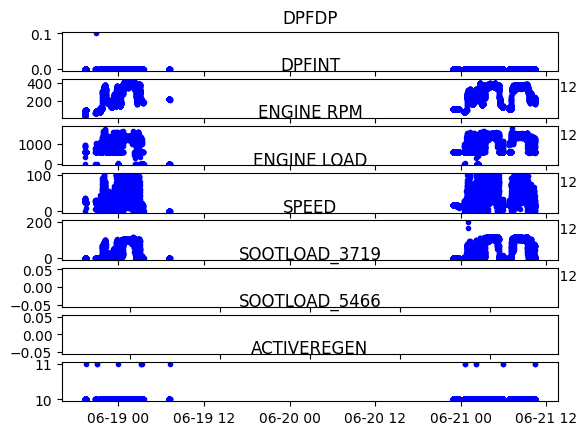

In [100]:
validation_status = DBQ_VALIDATION(OBD_data)

